# タイタニックの生存者予測

## 目的  
* データの整理、分析、簡単なモデル構築を学ぶための基本を身に着ける。  
* 結果をkaggleに投稿する。

## 検証①　ランダムフォレストで調査

必要なライブラリのインストール

In [1]:
#!pip install optuna
#!pip install lightgbm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

 # SVC: Support Vector Classificationをインポート
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

#Oputuna(ハイパーパラメータの最適化に使用するライブラリ)のインストール
import optuna

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

#warningを表示をしない設定にする。
import warnings
warnings.simplefilter('ignore')

C:\Users\Tsubasa\anaconda3\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### データの読み込み  
タイタニック号の乗客データを読み込む

In [3]:

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
                        
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#train_dataの'Survived'のデータ数の確認

train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

※そもそも訓練データは生存者(1)の方が少ない。

### データ前処理

In [5]:
test_id = test_data['PassengerId'] # 結果の提出時に使用

#訓練データ及びテストデータから判定に使える列のみを取り出す
labels=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
train_data=train_data[labels + ["Survived"]]
test_data=test_data[labels]

train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [6]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [7]:
#データの全体像を確認
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
 7   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null

AgeとFare、Embarkedに欠損が存在  
AgeとFareの欠損値には平均値を、Embarkedの欠損値には最頻値を補完する。

In [8]:
#Age
age_mean = train_data['Age'].mean() #平均値
train_data['Age'] = train_data['Age'].fillna(age_mean)
test_data['Age'] = test_data['Age'].fillna(age_mean)

#Fare
Fare_mean = train_data['Fare'].mean() #平均値
train_data['Fare'] = train_data['Fare'].fillna(Fare_mean)
test_data['Fare'] = test_data['Fare'].fillna(Fare_mean)

#Embarked
Embarked_mode=train_data['Embarked'].mode() #最頻値
train_data['Embarked'] = train_data['Embarked'].fillna(Embarked_mode)
test_data['Embarked'] = test_data['Embarked'].fillna(Embarked_mode)


In [9]:
#カテゴリ変数のカラムを抽出
cat_labels=['Sex','Pclass','Embarked']

#get_dummies()により、カテゴリ変数の列を0か1の値を持つ複数の列に変換
train_data=pd.get_dummies(train_data,columns=cat_labels)
test_data=pd.get_dummies(test_data,columns=cat_labels)

train_data.head()

,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,1,1,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,1,1,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,1,1,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,1


### モデルの訓練  
入力と正解を用意する。  
'Survived'の列が正解データ

In [10]:
y_train=train_data['Survived'] #正解

#'Survived'の列を削除して入力に
x_train=train_data.drop(labels = ['Survived'],axis=1)
x_test=test_data

In [11]:

#RandomForestClassifier()を使い、ランダムフォレストのモデルを作成して訓練
#n_estimators: 決定木の数  max_depth: 決定木の深さ
model = RandomForestClassifier(n_estimators=100,max_depth=5)
model.fit(x_train,y_train)


RandomForestClassifier(max_depth=5)

### 結果の確認と提出

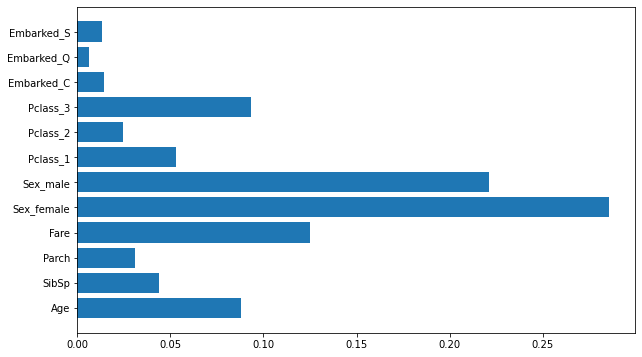

In [12]:
labels = x_train.columns

#feature_importances_により各特徴量の重要度を取得
importances=model.feature_importances_

#棒グラフで取得
plt.figure(figsize=(10,6))
plt.barh(range(len(importances)),importances)
plt.yticks(range(len(labels)),labels)
plt.show()


やはり、性別はかなり大きくかかわってくることがわかる。  
年齢の重要度がそんなに高くないのは意外。(若い人の人数がそもそも少なかったか)

In [13]:
#テストデータを使って、予測を行う。

#判定
y_test=model.predict(x_test)

#予測が0.5以上であれば1とする。
y_test=(y_test>0.5).astype(int)

#kaggle提出用にデータを整える
survived_test=pd.Series(y_test,name='Survived')
subm_data = pd.concat([test_id,survived_test],axis=1)

#csvファイルで保存
subm_data.to_csv('submission_titanic_rf.csv',index=False)

subm_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## 検証② サポートベクタマシンで調査

In [14]:

#モデル作成
model=SVC()

#モデルの訓練
model.fit(x_train,y_train)

SVC()

データの整理と結果の提出

In [15]:
y_test=model.predict(x_test)
y_test=(y_test>0.5).astype(int)


survived_test=pd.Series(y_test,name='Survived')
subm_data = pd.concat([test_id,survived_test],axis=1)

subm_data.to_csv('submission_titanic_svc.csv',index=False)

subm_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### kaggle提出  
スコア:0.66507

## 検証③ データの加工,特徴量追加

In [16]:
train_data=pd.read_csv('train.csv') #訓練データ
test_data=pd.read_csv('test.csv') #テストデータ

#データ型等の確認
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

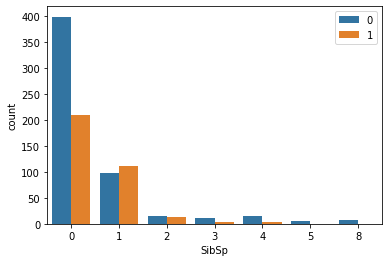

In [17]:
#'SipSp'(兄弟、配偶者)の分布を表示
sns.countplot(x='SibSp',hue='Survived',data=train_data)
plt.legend()
plt.show()

兄弟、配偶者が0人だと、生存率は低い。

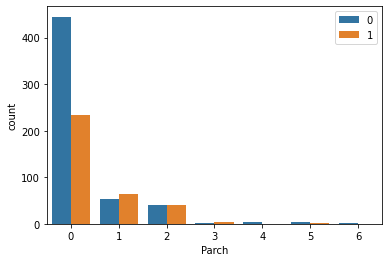

In [18]:
#Parch（親/子供の数）の分布を表示
sns.countplot(x='Parch',hue='Survived',data=train_data)
plt.legend()
plt.show()

親、子供がいないと生存率は低い

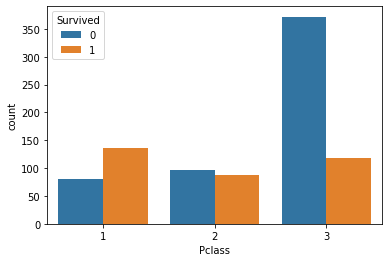

In [19]:
#Pclass（チケットのクラス）の分布を表示
sns.countplot(x='Pclass',hue='Survived',data=train_data)
plt.show()

3のチケットクラスの人は生存率が低い。  
1,2番のチケットは上流チケット(非常口が近いなど)？

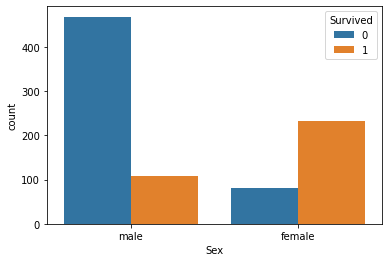

In [20]:
#性別の分布を表示
sns.countplot(x='Sex',hue='Survived',data=train_data)
plt.show()

男性の生存率は低く、女性の生存率が高い。

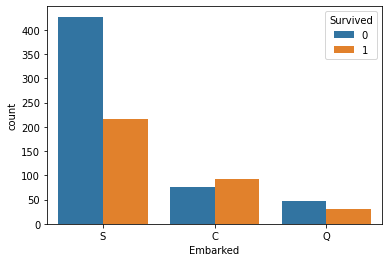

In [21]:
#Embarked（出港地）の分布を表示
sns.countplot(x='Embarked',hue='Survived',data=train_data)
plt.show()

Sの港から乗った人は生存率が低い  
→裕福な人が少ない街にある港の可能性？

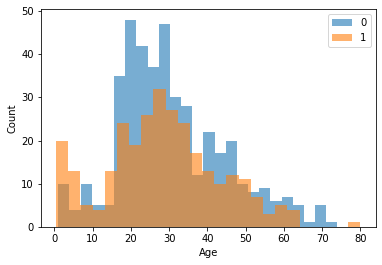

In [22]:
#Age(年齢)の分布を表示

bins = 25 #棒の数
alpha=0.6 #棒の透明度

#棒グラフの表示形式
plt.hist(train_data.loc[train_data['Survived']==0,'Age'].dropna(),bins=bins,alpha=alpha,label='0')
plt.hist(train_data.loc[train_data['Survived']==1,'Age'].dropna(),bins=bins,alpha=alpha,label='1')

#軸ラベルの設定
plt.xlabel('Age')
plt.ylabel('Count')

#出力
plt.legend()
plt.show()


0歳～20歳までの若い人の生存率は高い

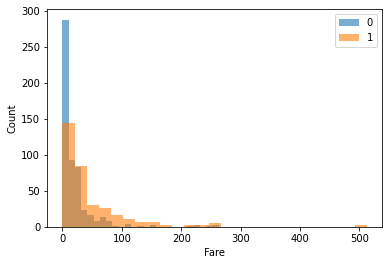

In [23]:
#同様にFare（料金）の分布を表示

plt.hist(train_data.loc[train_data['Survived']==0,'Fare'].dropna(),bins=25,alpha=0.6,label='0')
plt.hist(train_data.loc[train_data['Survived']==1,'Fare'].dropna(),bins=25,alpha=0.6,label='1')

plt.xlabel('Fare')
plt.ylabel('Count')

plt.legend()
plt.show()

値が大きいほど、生存率が高い。

必要なデータを学習に使えるように変換し、新しい特徴量を作成する。  


In [24]:
# テストデータ、訓練データを結合
data = pd.concat([train_data,test_data],sort=False)

# 性別を0か1の値に変換
data['Sex'].replace(['male','female'],[0,1],inplace=True)

# 出港地の欠損値を埋め、0、1、2の値に変換
data['Embarked'].fillna(('S'),inplace=True)
data['Embarked']=data['Embarked'].map({'S':0,'C':1,'Q':2})

# 欠損値を埋める
#inplaceをTrueにすることで、元のデータが変更されるようになる
data['Fare'].fillna(data['Fare'].mean(),inplace=True)
data['Age'].fillna(data['Age'].mean(),inplace=True)

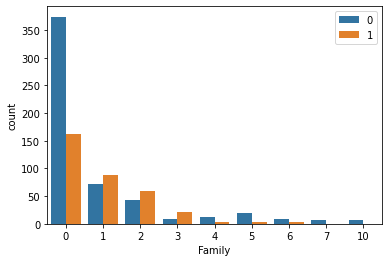

In [25]:
#SibSpとParchを合わせて、新しい特徴量「Family」を作る。
data['Family']=data['Parch'] + data['SibSp']

#0行目からlen(train_data)の891行目まで抽出
train_data['Family']=data['Family'][:len(train_data)]  #len(train_data) = 891

#891行目以降を抽出
test_data['Family'] = data['Family'][len(train_data):]

#棒グラフで抽出
sns.countplot(x='Family',data=train_data,hue='Survived')
plt.legend()
plt.show()

In [26]:
# 不要な特徴量の削除
data.drop(['Name','PassengerId','SibSp','Parch','Ticket','Cabin'],
           axis=1,inplace=True)

train_data = data[:len(train_data)]
test_data=data[len(train_data):]

#正解
t = train_data['Survived']

#訓練時の入力
x_train=train_data.drop('Survived',axis=1)

#テスト時の入力
x_test=test_data.drop('Survived',axis=1)

x_train.head()

,Pclass,Sex,Age,Fare,Embarked,Family
0,3,0,22.0,7.2500,0,1
1,1,1,38.0,71.2833,1,1
2,3,1,26.0,7.9250,0,0
3,1,1,35.0,53.1000,0,1
4,3,0,35.0,8.0500,0,0


## ハイパーパラメータの調節  
精度向上のために、ハイパーパラメータを調整します。

### データの準備  
データの読み込みと加工を行います。

In [27]:

train_data = pd.read_csv("train.csv")  # 訓練データ
test_data = pd.read_csv("test.csv") # テストデータ

test_id = test_data["PassengerId"]  # 結果の提出時に使用

data = pd.concat([train_data, test_data], sort=False)  # テストデータ、訓練データを結合

# カテゴリデータの変換
data["Sex"].replace(["male", "female"], [0, 1], inplace=True)
data["Embarked"].fillna(("S"), inplace=True)
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# 欠損値を埋める
data["Fare"].fillna(data["Fare"].mean(), inplace=True)
data["Age"].fillna(data["Age"].mean(), inplace=True)

# 新しい特徴量の作成
data["Family"] = data["Parch"] + data["SibSp"]

# 不要な特徴量の削除
data.drop(["Name", "PassengerId", "SibSp", "Parch", "Ticket", "Cabin"],
          axis=1, inplace=True)

# 入力と正解の作成
train_data = data[:len(train_data)]
test_data = data[len(train_data):]
t = train_data["Survived"]  # 正解
x_train = train_data.drop("Survived", axis=1)  # 訓練時の入力
x_test = test_data.drop("Survived", axis=1)  # テスト時の入力

x_train.head()

,Pclass,Sex,Age,Fare,Embarked,Family
0,3,0,22.0,7.2500,0,1
1,1,1,38.0,71.2833,1,1
2,3,1,26.0,7.9250,0,0
3,1,1,35.0,53.1000,0,1
4,3,0,35.0,8.0500,0,0


### データの分割  
訓練用データを訓練用と検証用に分割します。

In [28]:
x_train, x_valid, t_train, t_valid = train_test_split(x_train, t, test_size=0.3, stratify=t)

### ハイパーパラメータの最適化  
ハイパーパラメータ最適化のための関数を用意  
最適化には、Optunaというライブラリを使用  

また、機械学習のアルゴリズムには決定木をベースにした「LightGBM」を使用    
大量の決定木を使用し、ある決定木の予測結果から誤差の大きなデータをうまく予測できるように次の決定木を作成  

In [29]:
categorical_features = ["Embarked", "Pclass", "Sex"]

def objective(trial):
    # ハイパーパラメータの探索範囲
    params = {
        "objective": "binary",  # 二値分類
        "max_bin": trial.suggest_int("max_bin", 200, 500),  # 特徴量の最大分割数
        "learning_rate": 0.05,  # 学習率
        "num_leaves": trial.suggest_int("num_leaves", 16, 128)  # 分岐の末端の最大数
    }

    # データセットの作成
    lgb_train = lgb.Dataset(x_train, t_train, categorical_feature=categorical_features)
    lgb_val = lgb.Dataset(x_valid, t_valid, reference=lgb_train, categorical_feature=categorical_features)

    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val],
                      verbose_eval=20,  # 学習過程の表示間隔
                      num_boost_round=500,  # 学習回数の最大値
                      early_stopping_rounds=10)  # 連続して10回性能が向上しなければ終了

    y_valid = model.predict(x_valid, num_iteration=model.best_iteration)  # 訓練済みのモデルを使用
    score = log_loss(t_valid, y_valid)  # 二値の交差エントロピー誤差
    return score

Optunaを使い、ハイパーパラメータを最適化

In [30]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=30)

[I 2022-10-24 14:05:26,129] A new study created in memory with name: no-name-f49cc757-111f-4508-9687-26f63a848e66
[I 2022-10-24 14:05:26,236] Trial 0 finished with value: 0.40260225183199844 and parameters: {'max_bin': 218, 'num_leaves': 23}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2022-10-24 14:05:26,368] Trial 1 finished with value: 0.4064379121308965 and parameters: {'max_bin': 372, 'num_leaves': 82}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:26,486] Trial 2 finished with value: 0.4064379121308965 and parameters: {'max_bin': 267, 'num_leaves': 89}. Best is trial 0 with value: 0.40260225183199844.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	training's binary_logloss: 0.30637	valid_1's binary_logloss: 0.40724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-10-24 14:05:26,615] Trial 3 finished with value: 0.4064379121308965 and parameters: {'max_bin': 329, 'num_leaves': 46}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's binary_logloss: 0.430878	valid_1's binary_logloss: 0.469948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2022-10-24 14:05:26,725] Trial 4 finished with value: 0.4064379121308965 and parameters: {'max_bin': 372, 'num_leaves': 29}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:26,843] Trial 5 finished with value: 0.4064379121308965 and parameters: {'max_bin': 371, 'num_leaves': 56}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.298105	valid_1's binary_logloss: 0.406438
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Inf

[I 2022-10-24 14:05:26,971] Trial 6 finished with value: 0.40260225183199844 and parameters: {'max_bin': 401, 'num_leaves': 23}. Best is trial 0 with value: 0.40260225183199844.


[20]	training's binary_logloss: 0.430893	valid_1's binary_logloss: 0.469967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's binary_logloss: 0.350768	valid_1's binary_logloss: 0.416513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	training's binary_logloss: 0.30556	valid_1's binary_logloss: 0.404431
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.295567	valid_1's binary_logloss: 0.402602
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data 

[I 2022-10-24 14:05:27,114] Trial 7 finished with value: 0.4064379121308965 and parameters: {'max_bin': 456, 'num_leaves': 122}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:27,240] Trial 8 finished with value: 0.4064379121308965 and parameters: {'max_bin': 404, 'num_leaves': 68}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.298105	valid_1's binary_logloss

[I 2022-10-24 14:05:27,364] Trial 9 finished with value: 0.4064379121308965 and parameters: {'max_bin': 412, 'num_leaves': 31}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's binary_logloss: 0.430878	valid_1's binary_logloss: 0.469948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2022-10-24 14:05:27,477] Trial 10 finished with value: 0.4064379121308965 and parameters: {'max_bin': 430, 'num_leaves': 81}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:27,578] Trial 11 finished with value: 0.4064379121308965 and parameters: {'max_bin': 301, 'num_leaves': 82}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.298105	valid_1's binary_logloss: 0.406438
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to rem

[I 2022-10-24 14:05:27,688] Trial 12 finished with value: 0.4064379121308965 and parameters: {'max_bin': 410, 'num_leaves': 115}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:27,787] Trial 13 finished with value: 0.4064379121308965 and parameters: {'max_bin': 427, 'num_leaves': 97}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	training's binary_lo

[I 2022-10-24 14:05:27,894] Trial 14 finished with value: 0.4064379121308965 and parameters: {'max_bin': 319, 'num_leaves': 121}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:28,001] Trial 15 finished with value: 0.4064379121308965 and parameters: {'max_bin': 236, 'num_leaves': 52}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-10-24 14:05:28,106] Trial 16 finished with value: 0.4064379121308965 and parameters: {'max_bin': 245, 'num_leaves': 98}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:28,203] Trial 17 finished with value: 0.4064379121308965 and parameters: {'max_bin': 281, 'num_leaves': 92}. Best is trial 0 with value: 0.40260225183199844.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2022-10-24 14:05:28,314] Trial 18 finished with value: 0.4064379121308965 and parameters: {'max_bin': 350, 'num_leaves': 81}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2022-10-24 14:05:28,422] Trial 19 finished with value: 0.4064379121308965 and parameters: {'max_bin': 470, 'num_leaves': 97}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:28,525] Trial 20 finished with value: 0.4064379121308965 and parameters: {'max_bin': 400, 'num_leaves': 106}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-10-24 14:05:28,624] Trial 21 finished with value: 0.4064176407113222 and parameters: {'max_bin': 426, 'num_leaves': 25}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:28,738] Trial 22 finished with value: 0.4064379121308965 and parameters: {'max_bin': 304, 'num_leaves': 59}. Best is trial 0 with value: 0.40260225183199844.


[40]	training's binary_logloss: 0.351735	valid_1's binary_logloss: 0.41802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-10-24 14:05:28,936] Trial 23 finished with value: 0.4064379121308965 and parameters: {'max_bin': 294, 'num_leaves': 61}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's binary_logloss: 0.430878	valid_1's binary_logloss: 0.469948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2022-10-24 14:05:29,055] Trial 24 finished with value: 0.4064379121308965 and parameters: {'max_bin': 395, 'num_leaves': 120}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:29,152] Trial 25 finished with value: 0.4064379121308965 and parameters: {'max_bin': 278, 'num_leaves': 35}. Best is trial 0 with value: 0.40260225183199844.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2022-10-24 14:05:29,259] Trial 26 finished with value: 0.4064379121308965 and parameters: {'max_bin': 470, 'num_leaves': 77}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2022-10-24 14:05:29,368] Trial 27 finished with value: 0.4064379121308965 and parameters: {'max_bin': 277, 'num_leaves': 101}. Best is trial 0 with value: 0.40260225183199844.
[I 2022-10-24 14:05:29,471] Trial 28 finished with value: 0.4064379121308965 and parameters: {'max_bin': 272, 'num_leaves': 116}. Best is trial 0 with value: 0.40260225183199844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.298105	valid_1's binary_logloss: 0.406438
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [b

[I 2022-10-24 14:05:29,553] Trial 29 finished with value: 0.4071928735944915 and parameters: {'max_bin': 418, 'num_leaves': 20}. Best is trial 0 with value: 0.40260225183199844.


最も良いハイパーパラメータを表示

In [31]:
print(study.best_params)

{'max_bin': 218, 'num_leaves': 23}


上記のベストなハイパーパラメータを使用して予測を行う。

In [32]:
# ベストなハイパーパラメータの設定
params={
    'objective':'binary',  # 二値分類
    'max_bin':study.best_params['max_bin'],  #特徴量の最大分割数
    'learing_rate':0.05,  #学習率
    'num_leaves':study.best_params['num_leaves']  #分岐の末端の最大化
}

#データセットの作成
lgb_train=lgb.Dataset(x_train,t_train,categorical_feature=categorical_features)
lgb_val=lgb.Dataset(x_valid,t_valid,reference=lgb_train,categorical_feature=categorical_features)

#モデルの訓練
model=lgb.train(params,lgb_train,valid_sets=[lgb_train,lgb_val],
                  verbose_eval=20,  #学習過程の表示閲覧
                  num_boost_round=500,  #学習回数の最大値
                  early_stopping_rounds=10)  #連続して10回性能が向上しなければ終了

y_test=model.predict(x_test,num_iteration=model.best_iteration)  #訓練済みのモデルを使用

[LightGBM] [Warning] Unknown parameter: learing_rate
[LightGBM] [Warning] Unknown parameter: learing_rate
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Warning] Unknown parameter: learing_rate
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

### 提出用のデータ  
提出量データの形式を整え、CSVファイルに保存します。

In [33]:
# 結果を0か1に
y_test=(y_test>0.5).astype(int)

#形式を整える
survived_test=pd.Series(y_test,name='Survived')
subm_data=pd.concat([test_id,survived_test],axis=1)

#提出用のcsvファイルを保存
subm_data.to_csv('submission_titanic_hp.csv',index=False)

subm_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### kaggle提出  
'submission_titanic_hp.csv' → アルゴリズムはlightGBM

スコア:0.66507 → 0.78468  
1825位/13427位中  
ハイパーパラメータを調節することで精度向上

## 交差検証 過学習の対処  
scikit-learnのStratifiedKFoldにより交差検証  
(StratifiedKFoldを使えば検証用データ中の0と1の割合を一定に保つことができる)

必要なデータのセットを改めて行う。

In [34]:
train_data = pd.read_csv("train.csv")  # 訓練データ
test_data = pd.read_csv("test.csv") # テストデータ

test_id = test_data["PassengerId"]  # 結果の提出時に使用

data = pd.concat([train_data, test_data], sort=False)  # テストデータ、訓練データを結合

# カテゴリデータの変換
data["Sex"].replace(["male", "female"], [0, 1], inplace=True)
data["Embarked"].fillna(("S"), inplace=True)
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# 欠損値を埋める
data["Fare"].fillna(data["Fare"].mean(), inplace=True)
data["Age"].fillna(data["Age"].mean(), inplace=True)

# 新しい特徴量の作成
data["Family"] = data["Parch"] + data["SibSp"]

# 不要な特徴量の削除
data.drop(["Name", "PassengerId", "SibSp", "Parch", "Ticket", "Cabin"],
          axis=1, inplace=True)

# 入力と正解の作成
train_data = data[:len(train_data)]
test_data = data[len(train_data):]
t = train_data["Survived"]  # 正解
x_train = train_data.drop("Survived", axis=1)  # 訓練時の入力
x_test = test_data.drop("Survived", axis=1)  # テスト時の入力

x_train.head()

,Pclass,Sex,Age,Fare,Embarked,Family
0,3,0,22.0,7.2500,0,1
1,1,1,38.0,71.2833,1,1
2,3,1,26.0,7.9250,0,0
3,1,1,35.0,53.1000,0,1
4,3,0,35.0,8.0500,0,0


交差検証

In [35]:
y_valid=np.zeros((len(x_train),))  #予測結果:検証用データ
y_test=[]  #予測結果:テスト用データ

skf = StratifiedKFold(n_splits=5,shuffle=True)

In [36]:
y_valids = np.zeros((len(x_train),)) # 予測結果: 検証用データ
y_tests = []  # 予測結果: テスト用データ

skf = StratifiedKFold(n_splits=5, shuffle=True)

# ハイパーパラメータの設定
params = {
    "objective": "binary",  # 二値分類
    "max_bin": 300,  # 特徴量の最大分割数
    "learning_rate": 0.05,  # 学習率
    "num_leaves": 32  # 分岐の末端の最大数
}

categorical_features = ["Embarked", "Pclass", "Sex"]

for _, (ids_train, ids_valid) in enumerate(skf.split(x_train, t)):
    x_tr = x_train.loc[ids_train, :]
    x_val = x_train.loc[ids_valid, :]
    t_tr = t[ids_train]
    t_val = t[ids_valid]

    # データセットの作成
    lgb_train = lgb.Dataset(x_tr, t_tr, categorical_feature=categorical_features)
    lgb_val = lgb.Dataset(x_val, t_val, reference=lgb_train, categorical_feature=categorical_features)
    
    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val],
                      verbose_eval=20,  # 学習過程の表示間隔
                      num_boost_round=500,  # 学習回数の最大値
                      early_stopping_rounds=10)  # 連続して10回性能が向上しなければ終了

    # 結果を保持
    y_valids[ids_valid] = model.predict(x_val, num_iteration=model.best_iteration)
    y_test = model.predict(x_test, num_iteration=model.best_iteration)
    y_tests.append(y_test)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

### 正解率  
検証用データによる予測結果と正解を使い、正解率を計算する。

In [37]:
y_valids_bin=(y_valids>0.5).astype(int)
accuracy_score(t,y_valids_bin)

0.8316498316498316

提出用のデータ  
形式を整えてcsvファイルに保存

In [38]:
y_test_subm=sum(y_tests)/len(y_tests)
y_test_subm=(y_test>0.5).astype(int)

survived_test = pd.Series(y_test_subm,name='Survived')
subm_data=pd.concat([test_id,survived_test],axis=1)

subm_data.to_csv('submision_titanic_cv.csv',index=False)

subm_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### 結果  
スコア:0.76555

### アンサンブル学習(複数の機械学習モデルを組み合わせる)

* データの準備  
* 異なる機械学習モデルによる予測結果を読み込み  
* これらを1つのデータフレームにまとめ、予測結果の相関関係を計算

In [39]:

subm_rf = pd.read_csv('submission_titanic_rf.csv')  #モデル:ランダムフォレスト
subm_svc = pd.read_csv('submission_titanic_svc.csv')  #モデル:SVC
subm_lgbm = pd.read_csv('submision_titanic_cv.csv')  #モデル:lightGBM

ensemble_df = pd.DataFrame({'subm_rf':subm_rf['Survived'].values,
                           'subm_svc':subm_svc['Survived'].values,
                           'subm_lgbm':subm_lgbm['Survived'].values,})

ensemble_df


,subm_rf,subm_svc,subm_lgbm
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,0,0
...,...,...,...
413,0,0,0
414,1,1,1
415,0,0,0
416,0,0,0


In [40]:
#各列の相関関係
ensemble_df.corr()

,subm_rf,subm_svc,subm_lgbm
subm_rf,1.000000,0.243118,0.849932
subm_svc,0.243118,1.000000,0.248414
subm_lgbm,0.849932,0.248414,1.000000


rfとlgbmは正の相関が強い  
rfとsvcは正の相関が弱い

### 多数決による生存/死亡の決定  
複数の機械学習モデルによる予測結果で多数決

In [41]:
subm_data = subm_rf.copy()  # PassengeterIdを転用

#多数決で生存/死亡の決定
#それぞれのモデルを足して、2以上になれば生存すると判定する。
subm_data['Survived']=subm_rf['Survived'] + subm_svc['Survived'] + subm_lgbm['Survived']
subm_data['Survived'] = (subm_data['Survived']>=2).astype(int)

subm_data.to_csv('submission_titanic_ensemble.csv',index=False)

subm_data.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


スコア:0.77990  
1791位/13376位